# Create visuals for blogpost on government stringency measures

In [1]:
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import pickle
import os
import shapefile
from datetime import datetime, timedelta
import operator
import math
import copy
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.ticker import NullLocator
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import matplotlib.cm as mcm
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
import matplotlib.gridspec as gridspec
import matplotlib
import seaborn as sns
from descartes import PolygonPatch
%matplotlib notebook

# change font
matplotlib.rcParams['font.sans-serif'] = "Lato"
matplotlib.rcParams['font.weight'] = "light"
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['axes.labelweight'] = 'bold'

**WARNING**: in the plots displayed inside the notebook that contain a colorbar, the colorbar spans the whole figure. However, that's an issue of the embedded plots only since the respective .png files saved as OK, i.e. the colorbar in on a side of the figure.

---

# <font color='red'> CHANGE `figures_dir` and `data_dir` </font>

In [2]:
cwd = os.getcwd()

# display(HTML("<style>.container { width:100% !important; }</style>"))

figures_dir = os.path.join(cwd, 'figures')
data_dir = os.path.join(cwd, 'data')

# Create local `data` and `figures` folder to store the data and figures respectively

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

## Download and save data from url

In [3]:
def download_data_from_url(url, folder_to_save, filename):
    
    req = requests.get(url)
    url_content = req.content

    with open(os.path.join(folder_to_save, filename), 'wb') as csv_file:
        csv_file.write(url_content)

### ECDC data on COVID-19 cases

In [4]:
ECDC_url = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx'

cases_filename = 'COVID-19_ECDC.xlsx'

download_data_from_url(ECDC_url, data_dir, cases_filename)

### Stringency Index by Oxford University

In [5]:
stringency_url = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'

stringency_filename = 'OxCGRT_latest.csv'

download_data_from_url(stringency_url, data_dir, stringency_filename)

---

## Load COVID-19 cases

In [6]:
df_cases = pd.read_excel(os.path.join(data_dir, cases_filename))

df_cases['cases_per_100000'] = (df_cases['cases'].astype('float')*100000)/df_cases['popData2019']

* Keep non-negative 'cases' and 'deaths'

In [7]:
df_cases = df_cases.loc[df_cases['cases'] >= 0]
df_cases = df_cases.loc[df_cases['deaths'] >= 0]

## Load Stringency Index

In [8]:
df_ox = pd.read_csv(os.path.join(data_dir, stringency_filename), low_memory=False, parse_dates=['Date'])

## Load GDP per capita from the World Bank : see https://data.worldbank.org/indicator/NY.GDP.PCAP.CD

In [9]:
df_gdp_per_capita = pd.read_csv(os.path.join(data_dir, 'gdp_per_capita.csv'), delimiter=',', skiprows=4)
display(df_gdp_per_capita)
display(df_gdp_per_capita['2019'])

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,24713.698045,26189.435509,26647.938101,27980.880695,28281.350482,29007.693003,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,59.773194,59.860874,58.458015,78.706388,82.095231,101.108305,...,641.871479,637.165523,613.856689,578.466353,547.228110,556.302002,524.162881,502.115487,NaN,NaN
2,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,5100.095808,5254.882338,5408.410496,4166.979684,3506.072885,4095.812942,3289.646664,2973.591160,NaN,NaN
3,Albania,ALB,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4247.629984,4413.060861,4578.631994,3952.801215,4124.055726,4531.020806,5284.380184,5352.857411,NaN,NaN
4,Andorra,AND,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,38686.461264,39538.766722,41303.929371,35762.523074,37474.665406,38962.880354,41793.055258,40886.391165,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3596.804655,3891.266363,4080.330717,3603.025501,3780.003689,4045.614209,4419.914327,4417.509940,NaN,NaN
260,"Yemen, Rep.",YEM,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1446.536354,1607.152365,1673.146354,1395.439633,1033.733043,882.395759,968.159048,NaN,NaN,NaN
261,South Africa,ZAF,GDP per capita (current US$),NY.GDP.PCAP.CD,443.009816,454.962013,473.011615,511.497253,548.995942,584.704072,...,7501.469984,6832.456891,6433.187277,5734.633629,5272.918425,6132.479841,6374.028196,6001.400814,NaN,NaN
262,Zambia,ZMB,GDP per capita (current US$),NY.GDP.PCAP.CD,232.188867,220.042137,212.578123,213.896441,242.384333,303.281910,...,1763.072733,1878.907001,1763.057298,1337.796110,1280.578898,1534.865371,1556.334482,1291.343357,NaN,NaN


0               NaN
1        502.115487
2       2973.591160
3       5352.857411
4      40886.391165
           ...     
259     4417.509940
260             NaN
261     6001.400814
262     1291.343357
263     1463.985910
Name: 2019, Length: 264, dtype: float64

---

## Functions definition for plotting

Dates of physical distancing or lockdown measures implemented by governments in `load_measures()` were manually selected from ACAPS Excel file listing all measures in various areas (health, physical distancing, travels ban, lockdowns, economy, ...) from https://www.acaps.org/covid-19-government-measures-dataset

In [10]:
def load_measures(country):

    measures = {'MYS': [(datetime(2020,3,18),'lockdown'),(datetime(2020,5,7),'measures\nloosened')],
                'IDN':[(datetime(2020,3,16),'physical\ndistancing\nenacted'), (datetime(2020,5,7),'resumption\ndomestic\nflights')
                       #(datetime(2020,4,27),'ban on going\nhome for\nRamadan')
                      ],
                'IND':[#(datetime(2020,3,5),'public\ngatherings\nlimited'),
                       #(datetime(2020,3,14),'emergency\nprotocols\ninvoked'),
                       (datetime(2020,3,24),'lockdown'), (datetime(2020,4,25),'shops\nreopening')],
                'MEX':[(datetime(2020,3,14),'public\nhealth\nmeasures'),
                       #(datetime(2020,3,30),'lockdown'),
                       (datetime(2020,5,18),'partial\nreopening')
                       #, (datetime(2020,6,1),'total\nreopening')
                      ],
                'NGA':[#(datetime(2020,3,23),'schools\nclosed\n(Lagos)'),
                       (datetime(2020,3,30),'domestic\ntravel\nrestrictions'),
                       (datetime(2020,6,2),'partial\nreopening')
                      ],
                'COL':[(datetime(2020,3,12),'health\nemergency\ndeclared'),
                       (datetime(2020,5,5),'partial\nreopening')],
                'CIV':[(datetime(2020,3,24),'national\ncurfew'),
                       (datetime(2020,5,8),'total\nreopening')],
                'MMR':[(datetime(2020,3,13),'suspension of\npublic gatherings')],
                'MOZ':[(datetime(2020,3,23),'limit public\ngatherings'),
                       (datetime(2020,6,28),'international\nflights\nallowed')
                      ],
                'UKR':[(datetime(2020,3,15),'lockdown'),
                       (datetime(2020,5,22),'partial\nreopening')],
                'AUS':[(datetime(2020,3,29),'lockdown'),
                       (datetime(2020,5,22),'partial\nreopening')],
                'DEU':[(datetime(2020,3,16),'non-essential\npublic\nservices\nclosed'),
                       (datetime(2020,5,15),'internal\ntransport\nresumed')],
                'GBR':[(datetime(2020,3,24),'lockdown'),
                       (datetime(2020,5,10),'go to\nwork\nallowed')],
                'ITA':[(datetime(2020,3,23),'lockdown'),
                       (datetime(2020,5,10),'businesses\nreopening')],
                'SGP':[(datetime(2020,4,7),'limit public gatherings'),
                       (datetime(2020,6,19),'businesses reopening')]
               }
    
    return measures.get(country,[])

In [11]:
def plot_cases(df_cases, col_df_cases, ax, color_cases, country, y_min=None, y_max=None):
    indx_country_cases = df_cases['countryterritoryCode'] == country
    df_cases_country = df_cases.loc[indx_country_cases]
        
#     # Second axes that shares the same x-axis to plot df_cases
#     ax2 = ax.twinx()
#     # ax2.plot(df_cases_country['dateRep'].values, df_cases_country[col_df_cases].values, '.', color='mediumseagreen', zorder=2, ms=4)
#     ax2.plot(df_cases_country['dateRep'], df_cases_country[col_df_cases].rolling(window=7, min_periods=1).mean(), marker='', lw=1, color='mediumseagreen')
#     ax2.set_ylabel('New COVID-19 cases per 100k inhabitants', color='mediumseagreen')  #fontsize=20, we already handled the x-label with ax1
#     ax2.tick_params(axis='y', labelcolor='mediumseagreen') # labelsize=20    
    
    ax.plot(df_cases_country['dateRep'], df_cases_country[col_df_cases], '.', color=color_cases, zorder=2, ms=4, alpha=.5)
    ax.plot(df_cases_country['dateRep'], df_cases_country[col_df_cases].rolling(window=window, min_periods=1).mean(), color=color_cases, lw=2, label='cases per 100k pop. ({} day average)'.format(window), zorder=2)

    if col_df_cases == 'cases_per_100000':
        # ax.set_title('New COVID-19 cases per 100k population')
        ax.set_ylabel('New COVID-19 cases per 100k population', weight='bold')
    
    if y_min:
        ax.set_ylim(y_min, ax.get_ylim()[1])
    if y_max:
        ax.set_ylim(ax.get_ylim()[0], y_max)
    
    # t_ = [datetime(2020,2,3) + timedelta(days = 7*w) for w in range(100) if ((datetime(2020,2,3)+timedelta(days = 7*w))-t_end).days < 3][::3]
    # ax.set_xticks(t_,[tt.strftime('%d.%m') for tt in t_])
    ax.grid(lw=0.5,alpha=0.8,zorder=1,color='#dcdcdc')
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.set_xlim(datetime(2020,1,31,12),t_end+timedelta(days=1))
    # ax.set_ylim(y_min,y_max)

In [12]:
def plot_stringency(df_ox, col_df_ox, ax, color_ox, country):
    indx_country_ox = (df_ox['CountryCode'] == country) & (df_ox['RegionName'].isnull())
    # df_ox['RegionName'].isnull() is necessary since e.g. in GBR (UK) the measures are disaggregated by State as well (Northern Ireland, Scotland, England, Wales)
    df_ox_country = df_ox.loc[indx_country_ox]

    ax.plot(df_ox_country['Date'], df_ox_country[col_df_ox], 'o-', color=color_ox, lw=1, ms=2, label='stringency index')
    if col_df_ox == 'StringencyIndexForDisplay':
        # ax.set_title('Stringency Index')
        ax.set_ylabel('Stringency Index', weight='bold')
        
    # t_ = [datetime(2020,2,3) + timedelta(days = 7*w) for w in range(100) if ((datetime(2020,2,3)+timedelta(days = 7*w))-t_end).days < 3][::3]
    # ax.set_xticks(t_,[tt.strftime('%d.%m') for tt in t_])
    ax.grid(lw=0.5,alpha=0.8,zorder=1,color='#dcdcdc')
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.set_xlim(datetime(2020,1,31,12),t_end+timedelta(days=1))
    ax.set_ylim(ax.get_ylim()[0],100-ax.get_ylim()[0])

* #### Number of countries vs first day of maximum stringency index

In [13]:
def hist_countries_vs_date_max_stringency(df_input, freq_datespan, orientation, fs, ticksize, colormap):
    
    only_national = df_input['RegionName'].isnull()
    
    df_national = df_input.loc[only_national]
    grp_national = df_national.groupby('CountryName')
    
    colmax = grp_national['StringencyIndexForDisplay'].max() 
    
    list_first_date_max_stringency = []
    
    # df_date_edges = pd.date_range(start = df_input['Date'].min(), end = df_input['Date'].max(), freq = '7D')
    # list_date_edges = np.arange(df_input['Date'].min(), df_input['Date'].max(), dtype='datetime64[W]')

    min_date, max_date = df_input['Date'].min(), df_input['Date'].max()
    
    for name, group in grp_national:
        indx_max_stringency = group['StringencyIndexForDisplay'] == group['StringencyIndexForDisplay'].max()
        # Get the first day of max strinngency
        indx_first_date_max_stringency = group.loc[indx_max_stringency]['Date'].min()
        list_first_date_max_stringency.append(indx_first_date_max_stringency.to_datetime64())
    
    df_first_date_max_stringency = pd.Series(sorted(list_first_date_max_stringency), dtype='datetime64[ns]')
    
    # Check if the year is always the same, since df_first_date_max_stringency.dt.week is the week number of that year.
    # If there are different years, then a reference to this info should be included in the plot from the weekday
    if df_first_date_max_stringency.dt.year.nunique() == 1:

        bottom_date = '2020-03-01'
        top_date = '2020-08-30'
        
        ## pd.date_range(min_date, max_date, freq='W-MON') below starts from Sunday (excluded), could start from any other day (excluded) using freq='W-MON' for example. 
        ## If min_date it is after then the first week is incomplete and does not get inside the range
        # df_dates_range = pd.date_range(min_date, max_date, freq='W-MON')        
        res = df_first_date_max_stringency.groupby(pd.cut(df_first_date_max_stringency, 
                                                              pd.date_range(min_date, max_date, freq=freq_datespan))).count()

        aggr_date_range = pd.date_range(min_date, bottom_date, periods=1).append(pd.date_range(bottom_date, top_date, freq=freq_datespan)).append(pd.DatetimeIndex([max_date]))
        list_aggr_date_range = aggr_date_range.tolist()
        
        res_aggr = df_first_date_max_stringency.groupby(pd.cut(df_first_date_max_stringency, aggr_date_range)).count()
        
#         for i, group in df_first_date_max_stringency.groupby(pd.cut(df_first_date_max_stringency, aggr_date_range)):
#             print(i)
#             display(group)
        
        ## Define discrete colors for the colorbar and for bars of the histogram plot.
        # Discard first and last dates since I don't want to plot them since they are at the limits of the range
        bounds = [mdates.date2num(i + timedelta(days=1)) for i in list_aggr_date_range[1:-1:2]]
        # mdates.date2num(datetime.strptime(i, "%Y-%m-%d"))
        out_bounds_min, out_bounds_max = mdates.date2num(list_aggr_date_range[0]), mdates.date2num(list_aggr_date_range[-1])
        
        cmap = mcm.get_cmap(colormap)  # define the colormap
        
        # extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]

        # create the new map
        custom_cmap = mcolors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

        # define the bins and normalize
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        # Instead of the interval in days corresponding to the week, get only the corresponding Monday to then substitute the x ticks
        # monday_of_week = [(c.left + timedelta(days=1)) for c in res.index.categories]
        # monday_of_week_str = [date.strftime('%d.%m') for date in monday_of_week]
        
        if orientation == 'horizontal':
        
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
            
#             gs = gridspec.GridSpec(2, 2, height_ratios=[0.05,1])
#             fig = plt.figure()
#             ax  = fig.add_subplot(gs[1,0], projection='3d')
#             cax = fig.add_subplot(gs[0,0])

#             surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap="coolwarm",
#                                linewidth=0, antialiased=False, vmin=-1, vmax=1)

#             fig.colorbar(surf, cax=cax, orientation="horizontal", ticks=[-1,0,1])

            ## Group dates of max stringency by week number of the year
            # count_first_date_max_stringency_per_week = df_first_date_max_stringency.groupby(df_first_date_max_stringency.dt.week).count()
            # count_first_date_max_stringency_per_week.plot(kind='bar', ax=ax)
            # display(df_first_date_max_stringency.apply(lambda x: x - timedelta(days=x.weekday())))

            # Define colors for the bars from the custom colormap. Bars have the same color 2 by 2 since once bar is one week while the colormap has one color for 2 weeks.
            custom_colors = [custom_cmap(norm(mdates.date2num(c.left + timedelta(days=1)))) for c in res_aggr.index.categories]            
            # custom_colors[0] = mcolors.to_rgba('0.9')
            custom_colors[0] = mcolors.to_rgba('0.7')
            custom_colors[-1] = mcolors.to_rgba('0.7')
            
            res_aggr.plot(kind='bar', align='edge', color=custom_colors, edgecolor='silver', width=1, ax=ax, zorder=2)
    
    
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="4%", pad=0.5)
    
            # custom_cmap.set_under('0.9')
            ## Same color set_under and set_over
            custom_cmap.set_under('0.7')
            custom_cmap.set_over('0.7')
            colbar = matplotlib.colorbar.ColorbarBase(cax, cmap=custom_cmap, norm=norm, spacing='uniform', 
                                             ticks=bounds, 
                                             boundaries=[out_bounds_min] + bounds + [out_bounds_max],
                                             extend='both',
                                             format=mdates.DateFormatter('%d.%m'), 
                                             orientation='horizontal')
        
            colbar.ax.tick_params(labelsize=ticksize)
        
            ax.tick_params(labelbottom=False)
            ax.tick_params(axis='y', length=5, labelsize=ticksize)
            ax.set_ylabel('Number of countries', weight='bold', fontsize=fs)
            colbar.set_label('First day of maximum stringency index', weight='bold', fontsize=fs)
        
            ax.grid(axis='y',alpha=0.5,lw=0.5,zorder=1,color='k')

            fig_path = os.path.join(figures_dir, 'mobility_cases_stringency', "histo_num_countries_vs_first_day_max_stringency.png")

            
        elif orientation == 'vertical':
            
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
        
            # Define colors for the bars from the custom colormap. Bars have the same color 2 by 2 since once bar is one week while the colormap has one color for 2 weeks.
            custom_colors = [custom_cmap(norm(mdates.date2num(c.left + timedelta(days=1)))) for c in res_aggr.index.categories]
            custom_colors[0] = mcolors.to_rgba('0.9')
            custom_colors[-1] = mcolors.to_rgba('0.7')
            
            res_aggr.plot(kind='barh', align='edge', color=custom_colors, edgecolor='silver', width=1, ax=ax, zorder=2)
            
            # Adding colorbar only when orientation == 'vertical'
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("left", size="4%", pad="15%")            
            # #     # create a second axes for the colorbar
            # #     # ax2 = fig.add_axes([0.95, 0.1, 0.5, 0.8])
            colbar = matplotlib.colorbar.ColorbarBase(cax, cmap=custom_cmap, norm=norm, spacing='uniform', 
                                             ticks=bounds, 
                                             boundaries=[out_bounds_min] + bounds + [out_bounds_max],
                                             extend='both',
                                             format=mdates.DateFormatter('%d.%m'))
        
            colbar.ax.tick_params(labelsize=15)
            # Instead of the interval in days corresponding to the week, get only the corresponding Monday to then substitute the x ticks
            # monday_of_week = [(c.left + timedelta(days=1)).strftime('%d.%m') for c in res.index.categories]
            # ax.set_yticklabels(monday_of_week, rotation=45, ha='right')
            ax.tick_params(labelleft=False)
            ax.tick_params(axis='x', length=5, labelsize=15)
            ax.set_xlabel('Number of countries', weight='bold', fontsize=fs)
            # ax.set_ylabel('First day of maximum stringency index', weight='bold', fontsize=fs)        
        
            ax.grid(axis='x',alpha=0.5,lw=0.5,zorder=1,color='k')
            
            fig_path = os.path.join(figures_dir, 'mobility_cases_stringency', "histo_vertical_num_countries_vs_first_day_max_stringency.png")

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)    
     
    fig.tight_layout()
    fig.savefig(fig_path, dpi=300, bbox_inches=0, pad=0)

**Display countries where first day of maximum stringency is before `sel_first_day`**

In [14]:
sel_first_day = '2020-03-01'

only_national = df_ox['RegionName'].isnull()

df_national = df_ox.loc[only_national]
grp_national = df_national.groupby('CountryName')

colmax = grp_national['StringencyIndexForDisplay'].max() 

list_first_date_max_stringency = []
list_first_date_max_stringency_countries = []

for name, group in grp_national:
    indx_max_stringency = group['StringencyIndexForDisplay'] == group['StringencyIndexForDisplay'].max()
    # Get the first day of max strinngency
    indx_first_date_max_stringency = group.loc[indx_max_stringency]['Date'].min()
    list_first_date_max_stringency.append(indx_first_date_max_stringency.to_datetime64())
    list_first_date_max_stringency_countries.append(name)
    
df_first_day_max_stringency = pd.DataFrame({'country':list_first_date_max_stringency_countries, 'first_day_max_stringency':list_first_date_max_stringency})

df_first_day_max_stringency.loc[df_first_day_max_stringency['first_day_max_stringency'] < sel_first_day]

,country,first_day_max_stringency
101,Macao,2020-02-17


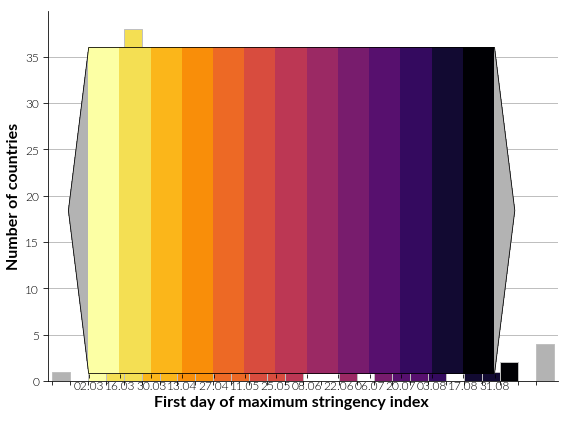

In [15]:
hist_countries_vs_date_max_stringency(df_ox.loc[df_ox['Date'] < '2020-10-16'], 'W', 'horizontal', 16, 12, 'inferno_r') #'viridis', 'cividis', 'plasma'

---

* #### Number of countries vs COVID-19 cases first day of maximum stringency index

In [16]:
df_cases[df_cases['countryterritoryCode'] == 'DEU'][['dateRep', 'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000']]

d = datetime(2020,4,7)

df_country = df_cases[df_cases['countryterritoryCode'] == 'DEU']
dates_r =  df_country['dateRep'].isin(pd.date_range(start=d - timedelta(days=14-1), end=d, freq='D'))

print(len(pd.date_range(start=d-timedelta(days=14-1), end=d, freq='D')))
display(dates_r.sum())

display(df_country.loc[df_country['dateRep'] == d][['dateRep','Cumulative_number_for_14_days_of_COVID-19_cases_per_100000']])

print(df_country.loc[dates_r]['cases_per_100000'].sum())
print(df_country.loc[dates_r]['cases'].sum()*100000/df_country['popData2019'].unique()[0])

14


14

,dateRep,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
22131,2020-04-07,84.33349


84.3334903692715
84.3334903692715


---

### Geographical maps of countries colored according to a given value/indicator

* Loading geopandas GeoDataframe from file with 'geometry' column of country borders polygons + other info

In [17]:
gdf_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Remove Antarctica from GeoDataFrame
gdf_world = gdf_world[gdf_world['name']!="Antarctica"]

# Fix missing 'iso_a3' codes for countries with 'name'
gdf_world.loc[gdf_world['iso_a3'] == '-99']['name']

gdf_world.loc[gdf_world['name'] == 'France', 'iso_a3'] = 'FRA'
gdf_world.loc[gdf_world['name'] == 'Norway', 'iso_a3'] = 'NOR'
gdf_world.loc[gdf_world['name'] == 'Kosovo', 'iso_a3'] = 'XXK'
# gdf_world.loc[gdf_world['name'] == 'N. Cyprus', 'iso_a3'] = 'CYP'
gdf_world.loc[gdf_world['name'] == 'Somaliland', 'iso_a3'] = 'SOM'

In [18]:
def geomap_first_day_max_stringency(gdf_input, df_stringency, freq_datespan, all_dates, colormap, fs, ticksize, fig_name):
    
    only_national = df_stringency['RegionName'].isnull()
    
    df_stringency_national = df_stringency.loc[only_national]
    grp_stringency_national = df_stringency_national.groupby('CountryCode')
    
    # df_date_edges = pd.date_range(start = df_input['Date'].min(), end = df_input['Date'].max(), freq = '7D')
    # list_date_edges = np.arange(df_input['Date'].min(), df_input['Date'].max(), dtype='datetime64[W]')
    
    min_date, max_date = df_stringency['Date'].min(), df_stringency['Date'].max()
    
    # Create a DataFrame with country as index and first day of max stringency as values in the column
    
    list_first_date_max_stringency = []
    list_country_code = []
    
    for name, group in grp_stringency_national:
        indx_max_stringency = group['StringencyIndexForDisplay'] == group['StringencyIndexForDisplay'].max()
        # Get the first day of max strinngency
        list_country_code.append(name)
        indx_first_date_max_stringency = group.loc[indx_max_stringency]['Date'].min()
        list_first_date_max_stringency.append(indx_first_date_max_stringency.to_datetime64())

    df_first_date_max_stringency = pd.DataFrame({'first_day_max_stringency':list_first_date_max_stringency,
                                                 'first_day_max_stringency_numerical': [mdates.date2num(i) for i in list_first_date_max_stringency]},
                                                index=list_country_code)

    ## Easy way to put one more column in the GeoDataFrame then used to plot borders and colors/value from the new columns
    ## Merging df_first_date_max_stringency on gdf_input
    gdf_merged = gdf_input.merge(df_first_date_max_stringency, left_on = 'iso_a3', right_on = df_first_date_max_stringency.index, how='left')
    
    print('Missing countries in df_stringency')
    display(gdf_merged.loc[gdf_merged['first_day_max_stringency'].isnull()][['name', 'iso_a3']])
    
    # Check if the year is always the same, since df_first_date_max_stringency.dt.week is the week number of that year.
    # If there are different years, then a reference to this info should be included in the plot from the weekday
    if gdf_merged['first_day_max_stringency'].dt.year.nunique() == 1:

        bottom_date = '2020-03-01'
        top_date = '2020-08-30'
        
        ## pd.date_range(min_date, max_date, freq='W-MON') below starts from Sunday (excluded), could start from any other day (excluded) using freq='W-MON' for example. 
        ## If min_date it is after then the first week is incomplete and does not get inside the range
        # df_dates_range = pd.date_range(min_date, max_date, freq='W-MON')        
        # res = gdf_merged['first_day_max_stringency'].groupby(pd.cut(gdf_merged['first_day_max_stringency'], 
        #                                                       pd.date_range(min_date, max_date, freq=freq_datespan))).count()

        ## All dates including single group per all dates before bottom_date and another after top_date
        aggr_date_range = pd.date_range(min_date, bottom_date, periods=1).append(pd.date_range(bottom_date, top_date, freq=freq_datespan)).append(pd.DatetimeIndex([max_date]))
        list_aggr_date_range = aggr_date_range.tolist()
        ## Define discrete colors for the colorbar and for bars of the histogram plot.
        # Discard first and last dates since I don't want to plot them since they are at the limits of the range
        bounds = [mdates.date2num(i + timedelta(days=1)) for i in list_aggr_date_range[1:-1:2]]
        # mdates.date2num(datetime.strptime(i, "%Y-%m-%d"))
        out_bounds_min, out_bounds_max = mdates.date2num(list_aggr_date_range[0]), mdates.date2num(list_aggr_date_range[-1])

#         else:
#             ## Exclude dates before bottom_date and after top_date from plot
#             aggr_date_range = pd.date_range(bottom_date, top_date, freq=freq_datespan)
#             list_aggr_date_range = aggr_date_range.tolist()
#             res_aggr = gdf_merged['first_day_max_stringency'].groupby(pd.cut(gdf_merged['first_day_max_stringency'], aggr_date_range)).count()        
#             ## Define discrete colors for the colorbar and for bars of the histogram plot.
#             # Do not discard first and last dates since aggr_date_range already do not contain min_date and max_date
#             bounds = [mdates.date2num(i + timedelta(days=1)) for i in list_aggr_date_range[::2]]

        
        cmap = mcm.get_cmap(colormap)  # define the colormap
        # extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]

        # create the new map
        custom_cmap = mcolors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

        # define the bins and normalize
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        # Instead of the interval in days corresponding to the week, get only the corresponding Monday to then substitute the x ticks
        # monday_of_week = [(c.left + timedelta(days=1)) for c in res.index.categories]
        # monday_of_week_str = [date.strftime('%d.%m') for date in monday_of_week]
        
        ## Plotting
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

        ## Group dates of max stringency by week number of the year
        # count_first_date_max_stringency_per_week = df_first_date_max_stringency.groupby(df_first_date_max_stringency.dt.week).count()
        # count_first_date_max_stringency_per_week.plot(kind='bar', ax=ax)
        # display(df_first_date_max_stringency.apply(lambda x: x - timedelta(days=x.weekday())))

        ## Define colors for the bars from the custom colormap. Bars have the same color 2 by 2 since once bar is one week while the colormap has one color for 2 weeks.
        # custom_colors = [custom_cmap(norm(mdates.date2num(c.left + timedelta(days=1)))) for c in res_aggr.index.categories]            
        
        # Plot countries with not max stringency date
        
        ## The below line is ok to color the polygon but with the added argument hatch='///' does not display it
        gdf_merged.loc[gdf_merged['first_day_max_stringency_numerical'].isnull()].plot(ax=ax, edgecolor='grey', facecolor='0.7', linewidth=0.5)
        
        # matplotlib.rcParams['hatch.linewidth'] = 0.25
        # gdf_merged.loc[gdf_merged['first_day_max_stringency_numerical'].isnull()].apply(lambda x : ax.add_patch(PolygonPatch(x['geometry'],
        #                                                                                                                      fill=False,
        #                                                                                                                      edgecolor='grey',
        #                                                                                                                      hatch='|'*10+'-'*10,
        #                                                                                                                      linewidth=0.5)), axis=1)
    
        gdf_merged.loc[gdf_merged['first_day_max_stringency_numerical'].notnull()].plot(column='first_day_max_stringency_numerical',
                                                                                        ax=ax,
                                                                                        cmap=custom_cmap,
                                                                                        norm=norm,
                                                                                        edgecolor='grey', linewidth=0.5)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0)

        
        ## Including extended colorbar (and related boundaries)
        ## Same color for set_under and set_over
        # custom_cmap.set_under('0.9')
        custom_cmap.set_under('0.7')
        custom_cmap.set_over('0.7')
        
        colbar = matplotlib.colorbar.ColorbarBase(cax, cmap=custom_cmap, norm=norm, spacing='uniform', 
                                                  ticks=bounds, 
                                                  boundaries=[out_bounds_min] + bounds + [out_bounds_max],
                                                  extend='both',
                                                  format=mdates.DateFormatter('%d.%m'))


        colbar.ax.tick_params(labelsize=ticksize)
  
        ax.set_title('First day of maximum stringency index', weight='bold', fontsize=fs)
    
        # Hide ticks and labels
        ax.axis('off')

        fig_path = os.path.join(figures_dir, 'mobility_cases_stringency', fig_name)
        fig.tight_layout()
        fig.savefig(fig_path, dpi=300, bbox_inches=0, pad=0)
    
    return gdf_merged

**WARNING**: somehow the ``divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="2%", pad=0)`` does not work properly the first the function is executed so you have to reload the packages in the cell at the beginning of the notebook and then execute the function again...

**Adjust color for missing countries (not matching ISO code like Kosovo), those without a stringency and those with the day of max stringency before or after the limit dates**

Missing countries in df_stringency


,name,iso_a3
2,W. Sahara,ESH
20,Falkland Is.,FLK
23,Fr. S. Antarctic Lands,ATF
62,Guinea-Bissau,GNB
69,Eq. Guinea,GNQ
95,North Korea,PRK
109,Armenia,ARM
134,New Caledonia,NCL
159,N. Cyprus,-99
170,Macedonia,MKD


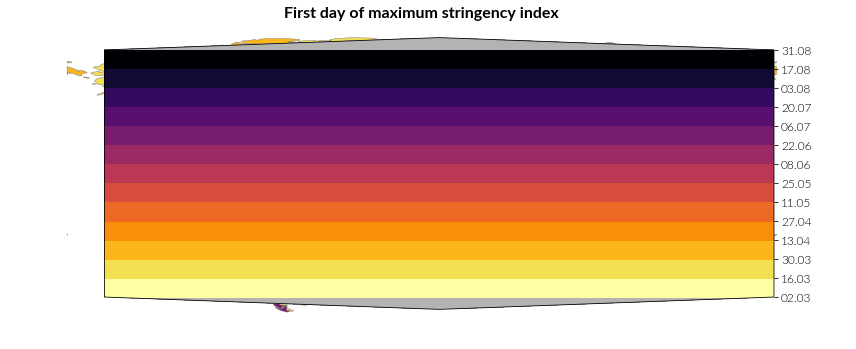

In [19]:
gdf_max_stringency = geomap_first_day_max_stringency(gdf_world, df_ox.loc[df_ox['Date'] < '2020-10-16'], 'W', True, 'inferno_r', 16, 12, 'geomap_first_day_max_stringency.png')

In [20]:
def geomap_total_cases_per_100k_at_first_day_max_stringency(gdf_input, df_stringency, df_cases, col_df_cases, freq_datespan, all_dates, colormap, fs, ticksize, fig_name):    
    
    only_national = df_stringency['RegionName'].isnull()
    
    df_stringency_national = df_stringency.loc[only_national]
    grp_stringency_national = df_stringency_national.groupby('CountryCode')
    
    # df_date_edges = pd.date_range(start = df_input['Date'].min(), end = df_input['Date'].max(), freq = '7D')
    # list_date_edges = np.arange(df_input['Date'].min(), df_input['Date'].max(), dtype='datetime64[W]')
    
    min_date, max_date = df_stringency['Date'].min(), df_stringency['Date'].max()
    
    # Create a DataFrame with country as index and first day of max stringency as values in the column
    
    list_first_day_max_stringency = []
    list_country_code = []
    list_total_cases_per_100k_at_first_day_max_stringency = []
    list_max_stringency = []
    
    for name, group in grp_stringency_national:
        indx_max_stringency = group['StringencyIndexForDisplay'] == group['StringencyIndexForDisplay'].max()
        list_max_stringency.append(group['StringencyIndexForDisplay'].max())
        # Get the first day of max strinngency
        list_country_code.append(name)
        indx_first_day_max_stringency = group.loc[indx_max_stringency]['Date'].min()
        list_first_day_max_stringency.append(indx_first_day_max_stringency.to_datetime64())
        
        df_cases_name = df_cases.loc[df_cases['countryterritoryCode'] == name]
        indx_dates_before_date_max_stringency = df_cases_name['dateRep'] <= indx_first_day_max_stringency
        total_cases_per_100k = df_cases_name.loc[indx_dates_before_date_max_stringency][col_df_cases].sum()
        list_total_cases_per_100k_at_first_day_max_stringency.append(total_cases_per_100k)

    df_first_day_max_stringency = pd.DataFrame({'first_day_max_stringency':list_first_day_max_stringency,
                                                 'first_day_max_stringency_numerical': [mdates.date2num(i) for i in list_first_day_max_stringency],
                                                 'total_cases_per_100k_at_first_day_max_stringency' : list_total_cases_per_100k_at_first_day_max_stringency,
                                                 'max_stringency' : list_max_stringency
                                                },
                                                index=list_country_code)

    ## Easy way to put one more column in the GeoDataFrame then used to plot borders and colors/value from the new columns
    ## Merging df_first_day_max_stringency on gdf_input
    gdf_merged = gdf_input.merge(df_first_day_max_stringency, left_on = 'iso_a3', right_on = df_first_day_max_stringency.index, how='left')
    
    # Check if the year is always the same, since df_first_day_max_stringency.dt.week is the week number of that year.
    # If there are different years, then a reference to this info should be included in the plot from the weekday
    if gdf_merged['first_day_max_stringency'].dt.year.nunique() == 1:

        bottom_date = '2020-03-01'
        top_date = '2020-08-30'
        
        ## pd.date_range(min_date, max_date, freq='W-MON') below starts from Sunday (excluded), could start from any other day (excluded) using freq='W-MON' for example. 
        ## If min_date it is after then the first week is incomplete and does not get inside the range
        # df_dates_range = pd.date_range(min_date, max_date, freq='W-MON')        
        # res = gdf_merged['first_day_max_stringency'].groupby(pd.cut(gdf_merged['first_day_max_stringency'], 
        #                                                       pd.date_range(min_date, max_date, freq=freq_datespan))).count()

        
        ## All dates including single group per all dates before bottom_date and another after top_date
        aggr_date_range = pd.date_range(min_date, bottom_date, periods=1).append(pd.date_range(bottom_date, top_date, freq=freq_datespan)).append(pd.DatetimeIndex([max_date]))
        list_aggr_date_range = aggr_date_range.tolist()
        res_aggr = gdf_merged['first_day_max_stringency'].groupby(pd.cut(gdf_merged['first_day_max_stringency'], aggr_date_range)).count()        
        ## Define discrete colors for the colorbar and for bars of the histogram plot.
        # Discard first and last dates since I don't want to plot them since they are at the limits of the range
        bounds = [mdates.date2num(i + timedelta(days=1)) for i in list_aggr_date_range[1:-1:2]]
        # mdates.date2num(datetime.strptime(i, "%Y-%m-%d"))
        out_bounds_min, out_bounds_max = mdates.date2num(list_aggr_date_range[0]), mdates.date2num(list_aggr_date_range[-1])            

        
        cmap = mcm.get_cmap(colormap)  # define the colormap
        # extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]

        # create the new map
        custom_cmap = mcolors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

        # define the bins and normalize
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        # Instead of the interval in days corresponding to the week, get only the corresponding Monday to then substitute the x ticks
        # monday_of_week = [(c.left + timedelta(days=1)) for c in res.index.categories]
        # monday_of_week_str = [date.strftime('%d.%m') for date in monday_of_week]
        
        ## Plotting
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

        ## Group dates of max stringency by week number of the year
        # count_first_day_max_stringency_per_week = df_first_day_max_stringency.groupby(df_first_day_max_stringency.dt.week).count()
        # count_first_day_max_stringency_per_week.plot(kind='bar', ax=ax)
        # display(df_first_day_max_stringency.apply(lambda x: x - timedelta(days=x.weekday())))

        ## Define colors for the bars from the custom colormap. Bars have the same color 2 by 2 since once bar is one week while the colormap has one color for 2 weeks.
        # custom_colors = [custom_cmap(norm(mdates.date2num(c.left + timedelta(days=1)))) for c in res_aggr.index.categories]            
        
        ## Plot total cases per 100k population at first day of max stringency
        indx_nnz = gdf_merged['total_cases_per_100k_at_first_day_max_stringency'] > 0
        min_total_cases_per_100k = gdf_merged.loc[indx_nnz]['total_cases_per_100k_at_first_day_max_stringency'].min()
        max_total_cases_per_100k = gdf_merged.loc[indx_nnz]['total_cases_per_100k_at_first_day_max_stringency'].max()
        
        indx_null = gdf_merged['first_day_max_stringency_numerical'].isnull()
        indx_ls_min_bounds = gdf_merged['first_day_max_stringency_numerical'] < min(bounds)
        indx_gt_max_bounds = gdf_merged['first_day_max_stringency_numerical'] > max(bounds)
        
        ## Plot countries colored in grey if out of the dates in bounds
        # gdf_merged.loc[indx_ls_min_bounds].plot(ax=ax, color='0.9', edgecolor='grey', linewidth=0.5)
        gdf_merged.loc[indx_ls_min_bounds].plot(ax=ax, color='0.7', edgecolor='grey', linewidth=0.5)
        gdf_merged.loc[indx_gt_max_bounds].plot(ax=ax, color='0.7', edgecolor='grey', linewidth=0.5)
        
        # countries_not_to_plot_cases = gdf_merged.loc[gdf_merged['first_day_max_stringency_numerical'].isnull()]['iso_a3'].values().tolist() + gdf_merged.loc[gdf_merged['first_day_max_stringency_numerical'] < min(bounds)]['iso_a3'].values().tolist() + gdf_merged.loc[gdf_merged['first_day_max_stringency_numerical'] > max(bounds)]['iso_a3'].values().tolist()
        
        
        gdf_merged.loc[~(indx_ls_min_bounds | indx_gt_max_bounds)].plot(column='total_cases_per_100k_at_first_day_max_stringency',
                                                                                        ax=ax,
                                                                                        cmap=custom_cmap,
                                                                                        norm=mcolors.LogNorm(vmin=min_total_cases_per_100k, vmax=max_total_cases_per_100k),
                                                                                        edgecolor='grey', linewidth=0.5)
        ## Substituting the line below for coloring with drawing hatches
        gdf_merged.loc[indx_null].plot(ax=ax, color='0.7', edgecolor='grey', linewidth=0.5)
        # matplotlib.rcParams['hatch.linewidth'] = 0.25
        # gdf_merged.loc[indx_null].apply(lambda x : ax.add_patch(PolygonPatch(x['geometry'],
        #                                                                      fill=False,
        #                                                                      edgecolor='grey',
        #                                                                      hatch='|'*10+'-'*10,
        #                                                                      linewidth=0.5)), axis=1)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0)

        if all_dates:        
            ## Including extended colorbar (and related boundaries)
            colbar = matplotlib.colorbar.ColorbarBase(cax, cmap=custom_cmap, norm=mcolors.LogNorm(vmin=min_total_cases_per_100k, vmax=max_total_cases_per_100k))
        else:
            # Not plotting the extension before bottom_date and after top_date since I don't want them
            colbar = matplotlib.colorbar.ColorbarBase(cax, cmap=custom_cmap, norm=mcolors.LogNorm(vmin=min_total_cases_per_100k, vmax=max_total_cases_per_100k))


        colbar.ax.tick_params(labelsize=ticksize)
  
        ax.set_title('Total COVID-19 cases per 100k population at first day of maximum stringency index', weight='bold', fontsize=fs)
    
        # Hide ticks and labels
        ax.axis('off')

        fig_path = os.path.join(figures_dir, 'mobility_cases_stringency', fig_name)
        fig.tight_layout()
        fig.savefig(fig_path, dpi=300, bbox_inches=0, pad=0)
    
    return gdf_merged

/anaconda/envs/py35/lib/python3.5/site-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


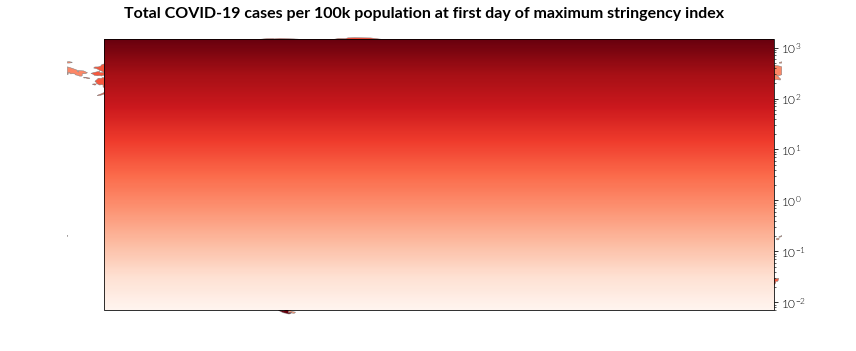

In [21]:
gdf_total_cases_per_100k = geomap_total_cases_per_100k_at_first_day_max_stringency(gdf_world, df_ox.loc[df_ox['Date'] < '2020-10-16'], df_cases, 'cases_per_100000', 'W', False, 'Reds', 16, 12, 'geomap_total_cases_per_100k_at_first_day_max_stringency.png')

---

In [22]:
def geomap_delay_max_cases_per_100k_and_first_day_max_stringency(gdf_input, df_stringency, df_cases, col_df_cases, bottom_date, top_date, bin_width_days, colormap, fs, ticksize, fig_name):
        
    # bottom_date = '2020-03-01'
    # top_date = '2020-08-30'
    # top_date = '2020-06-30'        
        
    only_national = df_stringency['RegionName'].isnull()
    
    df_stringency_national = df_stringency.loc[only_national]
    df_stringency_national = df_stringency_national.loc[(df_stringency_national['Date'] >= bottom_date) & (df_stringency_national['Date'] <= top_date)]
    grp_stringency_national = df_stringency_national.groupby('CountryCode')
    
    df_cases = df_cases.loc[(df_cases['dateRep'] >= bottom_date) & (df_cases['dateRep'] <= top_date)] 
    
    # df_date_edges = pd.date_range(start = df_input['Date'].min(), end = df_input['Date'].max(), freq = '7D')
    # list_date_edges = np.arange(df_input['Date'].min(), df_input['Date'].max(), dtype='datetime64[W]')
    
    # min_date, max_date = df_stringency['Date'].min(), df_stringency['Date'].max()
    
    # Create a DataFrame with country as index and first day of max stringency as values in the column
    
    list_first_day_max_stringency = []
    list_country_code = []
    list_first_day_max_moving_avg_cases = []
    list_max_stringency = []
    # Catch the date of stringency values close to the maximum (within max stringency - 10)
    list_first_day_sim_max_stringency = []
    
    for name, group in grp_stringency_national:
        max_stringency = group['StringencyIndexForDisplay'].max()
        indx_max_stringency = group['StringencyIndexForDisplay'] == max_stringency
        list_max_stringency.append(max_stringency)
        list_country_code.append(name)
        ## Get the first day of max strinngency
        indx_first_day_max_stringency = group.loc[indx_max_stringency]['Date'].min()
        list_first_day_max_stringency.append(indx_first_day_max_stringency.to_datetime64())
        ## Get first day with stringency similar to the maximum one
        ## Before filtering on max_stringency >= 50 but Japan (which did a good job) is < 50, so I removed the if condition
        # if max_stringency >= 50:
        indx_sim_max_stringency = group['StringencyIndexForDisplay'] > max_stringency-15
        indx_first_day_sim_max_stringency = group.loc[indx_sim_max_stringency]['Date'].min()
        list_first_day_sim_max_stringency.append(indx_first_day_sim_max_stringency.to_datetime64())

        #
        df_cases_name = df_cases.loc[df_cases['countryterritoryCode'] == name]
        if len(df_cases_name) == 0:
            day_max_moving_avg_cases = pd.NaT
        else:
            df_cases_name_moving_avg = df_cases_name[col_df_cases].rolling(window=7, min_periods=1).mean()
            indx_day_max_moving_avg_cases = df_cases_name_moving_avg.idxmax()
            day_max_moving_avg_cases = df_cases_name.loc[indx_day_max_moving_avg_cases]['dateRep']
        
        list_first_day_max_moving_avg_cases.append(day_max_moving_avg_cases.to_datetime64())

    df_first_day_max_stringency = pd.DataFrame({'first_day_max_stringency':list_first_day_max_stringency,
                                                 'first_day_max_stringency_numerical': [mdates.date2num(i) for i in list_first_day_max_stringency],
                                                 'first_day_max_' + col_df_cases : list_first_day_max_moving_avg_cases,
                                                 'max_stringency' : list_max_stringency,
                                                 'first_day_sim_max_stringency':list_first_day_sim_max_stringency
                                                },
                                                index=list_country_code)
    
    ## Adding column for the difference in days between max cases and max stringency
    df_first_day_max_stringency['delay_day_max_' + col_df_cases + '_first_day_max_stringency'] = df_first_day_max_stringency['first_day_max_' + col_df_cases] - df_first_day_max_stringency['first_day_max_stringency']
    df_first_day_max_stringency['delay_day_max_' + col_df_cases + '_first_day_max_stringency_numerical'] = df_first_day_max_stringency['delay_day_max_' + col_df_cases + '_first_day_max_stringency'].dt.days
    display(df_first_day_max_stringency.loc[df_first_day_max_stringency['delay_day_max_' + col_df_cases + '_first_day_max_stringency_numerical'] < 0])
    
    df_first_day_max_stringency['delay_day_max_' + col_df_cases + '_first_day_sim_max_stringency'] = df_first_day_max_stringency['first_day_max_' + col_df_cases] - df_first_day_max_stringency['first_day_sim_max_stringency']
    df_first_day_max_stringency['delay_day_max_' + col_df_cases + '_first_day_sim_max_stringency_numerical'] = df_first_day_max_stringency['delay_day_max_' + col_df_cases + '_first_day_sim_max_stringency'].dt.days

    display(df_first_day_max_stringency.loc[df_first_day_max_stringency['delay_day_max_' + col_df_cases + '_first_day_sim_max_stringency_numerical'] < 0])
    
    col_to_plot = 'delay_day_max_' + col_df_cases + '_first_day_sim_max_stringency_numerical'
    col_ref = 'first_day_sim_max_stringency'
    
    ## Other valid pair is
    # col_to_plot = 'delay_day_max_' + col_df_cases + '_first_day_max_stringency_numerical'
    # col_ref = 'first_day_max_stringency'
    
    fig_hist, ax_hist = plt.subplots(1,1,figsize=(6,4))
    df_first_day_max_stringency[col_to_plot].hist(bins=np.arange(df_first_day_max_stringency[col_to_plot].min(), df_first_day_max_stringency[col_to_plot].max()+1, 7), ax=ax_hist)
    
    ## Easy way to put one more column in the GeoDataFrame then used to plot borders and colors/value from the new columns
    ## Merging df_first_day_max_stringency on gdf_input
    gdf_merged = gdf_input.merge(df_first_day_max_stringency, left_on = 'iso_a3', right_on = df_first_day_max_stringency.index, how='left')
    
    # Check if the year is always the same, since df_first_day_max_stringency.dt.week is the week number of that year.
    # If there are different years, then a reference to this info should be included in the plot from the weekday
    if gdf_merged[col_ref].dt.year.nunique() == 1:
        
        ## pd.date_range(min_date, max_date, freq='W-MON') below starts from Sunday (excluded), could start from any other day (excluded) using freq='W-MON' for example. 
        ## If min_date it is after then the first week is incomplete and does not get inside the range
        # df_dates_range = pd.date_range(min_date, max_date, freq='W-MON')        
        # res = gdf_merged['first_day_max_stringency'].groupby(pd.cut(gdf_merged['first_day_max_stringency'], 
        #                                                       pd.date_range(min_date, max_date, freq=freq_datespan))).count()

        
        ## All dates including single group per all dates before bottom_date and another after top_date
        # aggr_date_range = pd.date_range(min_date, bottom_date, periods=1).append(pd.date_range(bottom_date, top_date, freq=freq_datespan)).append(pd.DatetimeIndex([max_date]))
        # list_aggr_date_range = aggr_date_range.tolist()
        # res_aggr = gdf_merged['first_day_max_stringency'].groupby(pd.cut(gdf_merged['first_day_max_stringency'], aggr_date_range)).count()        
        ## Define discrete colors for the colorbar and for bars of the histogram plot.
        # Discard first and last dates since I don't want to plot them since they are at the limits of the range
        # bounds = [mdates.date2num(i + timedelta(days=1)) for i in list_aggr_date_range[1:-1:2]]
        # mdates.date2num(datetime.strptime(i, "%Y-%m-%d"))
        # out_bounds_min, out_bounds_max = mdates.date2num(list_aggr_date_range[0]), mdates.date2num(list_aggr_date_range[-1])            

        
        cmap = mcm.get_cmap(colormap)  # define the colormap
        # extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]

        # create the new map
        custom_cmap = mcolors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
        
        ## Manually modified the upper limit since only 1 country has 120 days delay, all others are below 105
        # bounds = np.arange(0, df_first_day_max_stringency[col_to_plot].max(), bin_width_days)
        bounds = np.arange(0, 106, bin_width_days)
        
        # define the bins and normalize
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        
        # Instead of the interval in days corresponding to the week, get only the corresponding Monday to then substitute the x ticks
        # monday_of_week = [(c.left + timedelta(days=1)) for c in res.index.categories]
        # monday_of_week_str = [date.strftime('%d.%m') for date in monday_of_week]
        
        ## Plotting
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

        ## Group dates of max stringency by week number of the year
        # count_first_day_max_stringency_per_week = df_first_day_max_stringency.groupby(df_first_day_max_stringency.dt.week).count()
        # count_first_day_max_stringency_per_week.plot(kind='bar', ax=ax)
        # display(df_first_day_max_stringency.apply(lambda x: x - timedelta(days=x.weekday())))

        ## Define colors for the bars from the custom colormap. Bars have the same color 2 by 2 since once bar is one week while the colormap has one color for 2 weeks.
        # custom_colors = [custom_cmap(norm(mdates.date2num(c.left + timedelta(days=1)))) for c in res_aggr.index.categories]            
        
        # indx_nnz = (gdf_merged['first_day_max_' + col_df_cases] - gdf_merged['first_day_max_stringency']) > 0
        
        indx_null = gdf_merged[col_ref].isnull()
        # indx_ls_min_bounds = gdf_merged['first_day_max_stringency_numerical'] < mdates.date2num(datetime.strptime(bottom_date, "%Y-%m-%d"))
        # indx_gt_max_bounds = gdf_merged['first_day_max_stringency_numerical'] > mdates.date2num(datetime.strptime(top_date, "%Y-%m-%d"))
        indx_ls_min_bounds = gdf_merged[col_ref] < bottom_date
        indx_gt_max_bounds = gdf_merged[col_ref] > top_date


        ## Plot countries colored in grey if out of the dates in bounds
        # gdf_merged.loc[indx_ls_min_bounds].plot(ax=ax, color='0.9', edgecolor='grey', linewidth=0.5)
        
        if indx_ls_min_bounds.sum() > 0:
            gdf_merged.loc[indx_ls_min_bounds].plot(ax=ax, color='red', edgecolor='grey', linewidth=0.5)
        if indx_gt_max_bounds.sum() > 0:
            gdf_merged.loc[indx_gt_max_bounds].plot(ax=ax, color='black', edgecolor='grey', linewidth=0.5)
        
        # countries_not_to_plot_cases = gdf_merged.loc[gdf_merged['first_day_max_stringency_numerical'].isnull()]['iso_a3'].values().tolist() + gdf_merged.loc[gdf_merged['first_day_max_stringency_numerical'] < min(bounds)]['iso_a3'].values().tolist() + gdf_merged.loc[gdf_merged['first_day_max_stringency_numerical'] > max(bounds)]['iso_a3'].values().tolist()
        
        ## Plot colors by delay between max cases per 100k population and first day of max stringency
        gdf_merged.loc[~(indx_ls_min_bounds | indx_gt_max_bounds)].plot(column=col_to_plot,
                                                                        ax=ax,
                                                                        cmap=custom_cmap,
                                                                        norm=norm,
                                                                        edgecolor='grey', linewidth=0.5)
        
        
        
        ## Substituting the line below for coloring with drawing hatches
        gdf_merged.loc[indx_null].plot(ax=ax, color='0.7', edgecolor='grey', linewidth=0.5)
        # matplotlib.rcParams['hatch.linewidth'] = 0.25
        # gdf_merged.loc[indx_null].apply(lambda x : ax.add_patch(PolygonPatch(x['geometry'],
        #                                                                      fill=False,
        #                                                                      edgecolor='grey',
        #                                                                      hatch='|'*10+'-'*10,
        #                                                                      linewidth=0.5)), axis=1)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0)

        colbar = matplotlib.colorbar.ColorbarBase(cax, 
                                                  cmap=custom_cmap, 
                                                  norm=norm, 
                                                  spacing='uniform', 
                                                  ticks=bounds)

        # custom_cmap.set_over('cyan')
        custom_cmap.set_under('mediumseagreen')
        matplotlib.rcParams['hatch.linewidth'] = 0.25
        # gdf_merged.loc[gdf_merged[col_to_plot]<0].apply(lambda x : ax.add_patch(PolygonPatch(x['geometry'],
        #                                                                                      fill=False,
        #                                                                                      edgecolor='grey',
        #                                                                                      hatch='|'*6+'-'*6,
        #                                                                                      linewidth=0.5)), axis=1)


#         colbar = matplotlib.colorbar.ColorbarBase(cax, cmap=custom_cmap, norm=norm, spacing='uniform', 
#                                           ticks=bounds, 
#                                           boundaries=[out_bounds_min] + bounds + [out_bounds_max],
#                                           extend='both',
#                                           format=mdates.DateFormatter('%d.%m'))

        

        colbar.ax.tick_params(labelsize=ticksize)
        colbar.ax.set_title('Num. of days', fontsize=ticksize, weight='bold')

  
        ax.set_title('Delay between day of maximum cases and first day of high stringency index', weight='bold', fontsize=fs)
    
        # Hide ticks and labels
        ax.axis('off')

        fig_path = os.path.join(figures_dir, 'mobility_cases_stringency', fig_name)
        fig.tight_layout()
        fig.savefig(fig_path, dpi=300, bbox_inches=0, pad=0)
    
    return gdf_merged

Other useful maps for colorbar :  'viridis_r', 'cividis_r', 'plasma_r', 'inferno_r'

,first_day_max_cases_per_100000,first_day_max_stringency,first_day_max_stringency_numerical,first_day_sim_max_stringency,max_stringency,delay_day_max_cases_per_100000_first_day_max_stringency,delay_day_max_cases_per_100000_first_day_max_stringency_numerical
ABW,2020-03-24,2020-04-10,737525.0,2020-03-29,88.89,-17 days,-17.0
AND,2020-03-25,2020-04-08,737523.0,2020-03-25,56.48,-14 days,-14.0
AUS,2020-03-25,2020-04-02,737517.0,2020-03-24,73.15,-8 days,-8.0
BFA,2020-04-06,2020-05-04,737549.0,2020-03-23,89.81,-28 days,-28.0
BLZ,2020-04-09,2020-05-15,737560.0,2020-04-01,85.19,-36 days,-36.0
BRB,2020-04-02,2020-04-08,737523.0,2020-04-03,88.89,-6 days,-6.0
BRN,2020-03-13,2020-04-11,737526.0,2020-03-13,58.33,-29 days,-29.0
CHN,2020-03-01,2020-03-26,737510.0,2020-03-01,81.94,-25 days,-25.0
CUB,2020-04-08,2020-05-11,737556.0,2020-05-05,100.00,-33 days,-33.0
CYP,2020-03-30,2020-04-16,737531.0,2020-03-24,94.44,-17 days,-17.0


,first_day_max_cases_per_100000,first_day_max_stringency,first_day_max_stringency_numerical,first_day_sim_max_stringency,max_stringency,delay_day_max_cases_per_100000_first_day_max_stringency,delay_day_max_cases_per_100000_first_day_max_stringency_numerical,delay_day_max_cases_per_100000_first_day_sim_max_stringency,delay_day_max_cases_per_100000_first_day_sim_max_stringency_numerical
ABW,2020-03-24,2020-04-10,737525.0,2020-03-29,88.89,-17 days,-17.0,-5 days,-5.0
BRB,2020-04-02,2020-04-08,737523.0,2020-04-03,88.89,-6 days,-6.0,-1 days,-1.0
CUB,2020-04-08,2020-05-11,737556.0,2020-05-05,100.00,-33 days,-33.0,-27 days,-27.0
DMA,2020-03-23,2020-04-01,737516.0,2020-04-01,79.63,-9 days,-9.0,-9 days,-9.0
KHM,2020-03-21,2020-04-09,737524.0,2020-03-26,68.52,-19 days,-19.0,-5 days,-5.0
KOR,2020-03-01,2020-04-06,737521.0,2020-03-21,82.41,-36 days,-36.0,-20 days,-20.0
LAO,2020-03-25,2020-03-30,737514.0,2020-03-30,96.30,-5 days,-5.0,-5 days,-5.0
MOZ,2020-06-11,2020-06-17,737593.0,2020-06-17,80.56,-6 days,-6.0,-6 days,-6.0
SYC,2020-03-15,2020-04-09,737524.0,2020-04-08,93.52,-25 days,-25.0,-24 days,-24.0
TJK,2020-05-23,2020-06-20,737596.0,2020-06-03,65.74,-28 days,-28.0,-11 days,-11.0


/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/colors.py:1300: RuntimeWarning: invalid value encountered in greater_equal
  iret[xx >= b] = i
/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/colors.py:1304: RuntimeWarning: invalid value encountered in less
  iret[xx < self.vmin] = -1
/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/colors.py:1305: RuntimeWarning: invalid value encountered in greater_equal
  iret[xx >= self.vmax] = max_col


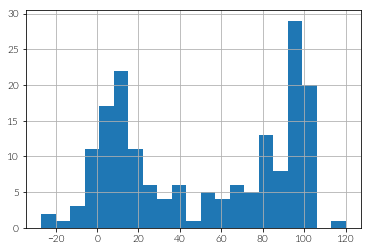

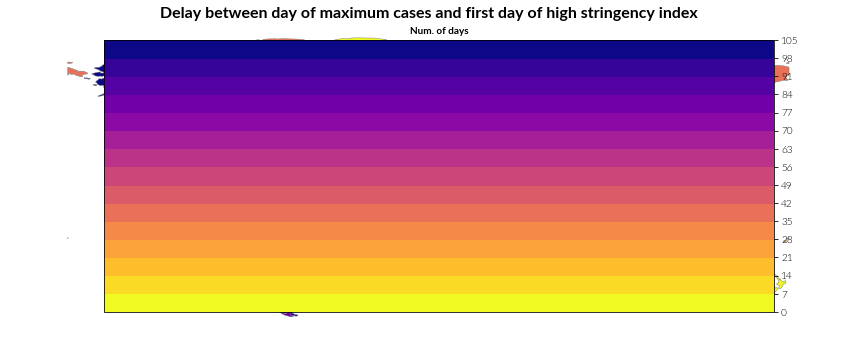

In [24]:
gdf_delay = geomap_delay_max_cases_per_100k_and_first_day_max_stringency(gdf_world, df_ox, df_cases, 'cases_per_100000', '2020-03-01', '2020-06-30', 7, 'plasma_r', 16, 10, 'geomap_delay_max_cases_per_100k_first_day_high_stringency.png')

---

## Plot separated cases, stringency and all together in the same plot

In [25]:
def plot_cases_stringency_same_fig(df_cases, col_df_cases, color_cases, df_ox, col_df_ox, color_ox, country):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
        
    # Plot COVID-19 cases
    plot_cases(df_cases, col_df_cases, ax, color_cases, country)
    ax.yaxis.label.set_color(color_cases)
    ax.tick_params(axis='y', colors=color_cases, labelcolor=color_cases)
    
    h,l = ax.get_legend_handles_labels()
    # h[0] and l[0] refers to the df_cases DataFrame column 'cases_per_100000' which we want to exclude from the plot
    
    ax2 = ax.twinx()
    # Plot Stringency Index
    plot_stringency(df_ox, col_df_ox, ax2, color_ox, country)
    ax2.yaxis.label.set_color(color_ox)
    ax2.tick_params(axis='y', colors=color_ox)
    
    h2,l2 = ax2.get_legend_handles_labels()
    
    ax.legend(h+h2, ['cases per 100k pop.', l[1]]+l2, loc='lower right', bbox_to_anchor=(1.0, 1.05), bbox_transform=ax.transAxes)
    
    # add measures to plot
    for i, (t_,r) in enumerate(measures):
        ax.axvline(x=t_,lw=1.1,color='b',ls='--', zorder=3)
        if i == 0:
            ax.text(t_,ax.get_ylim()[1],r,ha='center',va='bottom',weight='bold')
        else:
            ax.text(t_,ax.get_ylim()[1],r,ha='left',va='bottom',weight='bold')
    t_ = [datetime(2020,2,3) + timedelta(days = 7*w) for w in range(100) if ((datetime(2020,2,3)+timedelta(days = 7*w))-t_end).days < 3][::3]
    plt.xticks(t_,[tt.strftime('%d.%m') for tt in t_])
    plt.xlim(datetime(2020,1,30,12),t_end+timedelta(days=2))
    plt.title(abbr_to_name[country], weight='bold', y=1.2, loc='left', fontsize=15)
    # plt.ylim(y_min,y_max)
    # ax.set_xlim(t_start, t_end)

    fig_path = os.path.join(figures_dir, 'mobility_cases_stringency', country + "_cases_stringency.png")
    
    fig.tight_layout()
    
    fig.savefig(fig_path, dpi=300, bbox_inches=0, pad=0)
    
    return

In [26]:
abbr_to_name = {'CIV':"Côte d'Ivoire",
                'COL':'Colombia',
                'IDN':'Indonesia',
                'IND':'India',
                'MEX':'Mexico',
                'MMR':'Myanmar',
                'MOZ':'Mozambique',
                'MYS':'Malaysia',
                'NGA':'Nigeria',
                'UKR':'Ukraine',
                'AUS':'Australia',
                'DEU':'Germany',
                'GBR':'United Kingdom',
                'ITA':'Italy',
                'SGP':'Singapore',
                'ESP':'Spain',
                'SWE':'Sweden',
                'KOR':'South Korea',
                'IRL':'Ireland'
               }

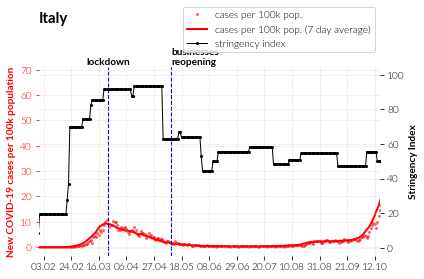

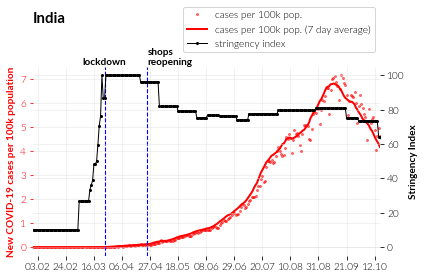

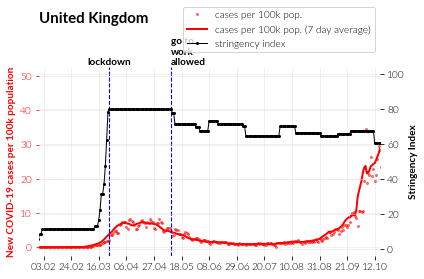

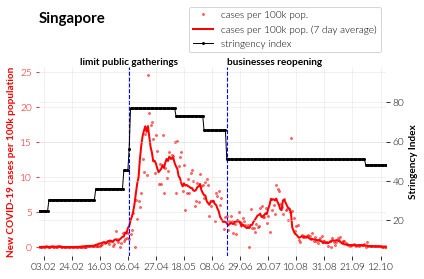

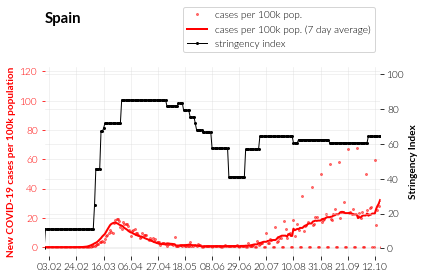

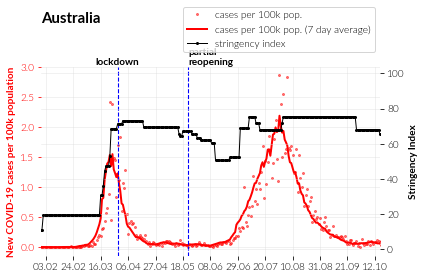

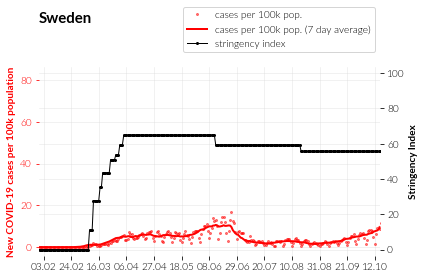

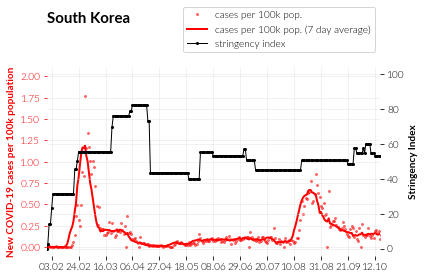

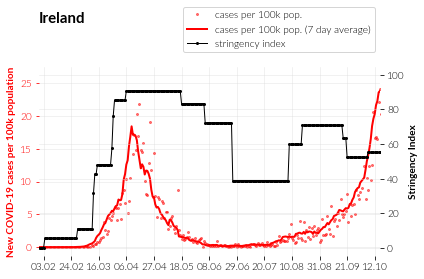

In [27]:
t_start = datetime(2020,2,1); t_day = t_start
# t_end = datetime(datetime.now().year,datetime.now().month,datetime.now().day) - timedelta(days=1)
t_end = datetime(2020,10,15) - timedelta(days=1)

countries_blogpost = ['ITA', 'IND', 'GBR', 'SGP', 'ESP', 'AUS', 'SWE', 'KOR', 'IRL']

window=7

for country in countries_blogpost:
    # load measures, data, and paths
    measures = load_measures(country)

    color_cases = 'red'
    color_ox = 'black'

    col_df_cases = 'cases_per_100000'
    col_df_ox = 'StringencyIndexForDisplay'


    plot_cases_stringency_same_fig(df_cases, col_df_cases, color_cases, df_ox, col_df_ox, color_ox, country)


## Plot 2D heatmap of cases_per_100000 and stringency for high, middle and low income countries (10 countries per each group)

In [28]:
def heatmap_2D_stringency_cases(gdf_input, df_stringency, df_cases, col_df_cases, quantity_cases, date_min, date_max, df_gdp_per_capita):

    # date_min = datetime(2020, 1, 1)
    # date_max = datetime(datetime.now().year,datetime.now().month,datetime.now().day) - timedelta(days=1)
    # date_max = datetime(2020, 10, 16) - timedelta(days=1)
    
    dd_date_min, mm_date_min = date_min.split('-')[2], date_min.split('-')[1]
    dd_mm_date_min = "-".join([dd_date_min, mm_date_min])

    dd_date_max, mm_date_max = date_max.split('-')[2], date_max.split('-')[1]
    dd_mm_date_max = "-".join([dd_date_max, mm_date_max])

    
    # Not all the countries (e.g. territories) from gdf_input are present in df_stringency or df_cases, so keep only those that are there!
    indx_countries_in_stringeny_cases = gdf_input['iso_a3'].isin(df_stringency['CountryCode']) & gdf_input['iso_a3'].isin(df_cases['countryterritoryCode'])
    gdf_plot = gdf_input.loc[indx_countries_in_stringeny_cases]
    
    # Filter on country population
    gdf_plot = gdf_plot.loc[gdf_plot['pop_est'] > 1*(10**6)]

    # gdf_plot['gdp_per_capita'] = gdf_plot['gdp_md_est'] / gdf_plot['pop_est']
    ## Add GDP per capita from World Bank in 2019
    gdf_plot['gdp_per_capita'] = gdf_plot['iso_a3'].map(pd.Series(df_gdp_per_capita['2019'].values, index=df_gdp_per_capita['Country Code']))
    
    # Compute division in high, low, and middle income countries
    gdf_plot['category_gdp_per_capita'] = pd.qcut(gdf_plot['gdp_per_capita'], 3, labels=['poor', 'middle', 'rich']) # retbins=True,
    
    fs = 13
    
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
    
    for i, gdp_cat in enumerate(['rich', 'middle', 'poor']):
        
        gdf_gdp_cat = gdf_plot.loc[gdf_plot['category_gdp_per_capita'] == gdp_cat]
        countries_gdp_cat = gdf_gdp_cat['iso_a3']
        gdf_selected_countries = gdf_gdp_cat.nlargest(10, 'gdp_per_capita', keep='all')
        top_gdp_per_capita_countries_code = gdf_selected_countries['iso_a3']
        
        if gdp_cat == 'rich':
            # Manually adding a bunch of countries for high-income
            list_index = []
            list_sel_ccs = ['ITA', 'DEU', 'ESP', 'GBR', 'FRA']
            for sel_cc in list_sel_ccs:
                list_index.append(countries_gdp_cat.loc[countries_gdp_cat == sel_cc].index[0])
            top_gdp_per_capita_countries_code = top_gdp_per_capita_countries_code.drop(top_gdp_per_capita_countries_code.loc[top_gdp_per_capita_countries_code == "QAT"].index, axis=0)
            top_gdp_per_capita_countries_code = top_gdp_per_capita_countries_code.append(pd.Series(list_sel_ccs, index=list_index), verify_integrity=True)
        
        # print(i, gdf_selected_countries[['name', 'iso_a3']])
        print(i, gdf_selected_countries['name'].values.tolist())
        
        # Stringency Index
        #
        df_stringency_coutries_by_gdp_per_capita = df_stringency.loc[df_stringency['CountryCode'].isin(countries_gdp_cat) & df_stringency['RegionName'].isnull()]
        
        # Filtering on dates
        #
        indx_dates = (df_stringency_coutries_by_gdp_per_capita['Date'] >= date_min) & (df_stringency_coutries_by_gdp_per_capita['Date'] <= date_max)
        df_stringency_coutries_by_gdp_per_capita = df_stringency_coutries_by_gdp_per_capita.loc[indx_dates]
        df_stringency_to_plot = df_stringency_coutries_by_gdp_per_capita.pivot(index='CountryCode', columns='Date', values='StringencyIndexForDisplay')
        ## Sort countries per mean/median stringency
        selected_countries = df_stringency_to_plot.mean(axis=1).nlargest(10, keep='all').index
        
        dict_country_codes_to_name = pd.Series(df_stringency['CountryName'].values, index=df_stringency['CountryCode']).to_dict()
        # dict_country_codes_to_name = pd.Series(df_cases['countriesAndTerritories'].str.replace("_", " ", regex=False).values, index=df_cases['countryterritoryCode']).to_dict()
        
        # To change the sorting modify here the top_gdp_per_capita_countries_code replacing with the desired one
        df_stringency_sel_countries = df_stringency_to_plot.loc[top_gdp_per_capita_countries_code]
        
        ax_stringency = ax[i][0]
        sns.heatmap(df_stringency_sel_countries, ax=ax_stringency, cmap='Greys', vmin=0, vmax=100, yticklabels=True)
        
        xticklabels = ax_stringency.get_xticklabels()
        xticklabels_text = [datetime.strptime(el.get_text().split(".")[0], '%Y-%m-%dT%H:%M:%S').strftime('%d.%m') for el in xticklabels]
        ## Change ticks and labels as well
        ax_stringency.set_xticks(ax_stringency.get_xticks()[::2])
        ## Only changing xticklabels string
        ax_stringency.set_xticklabels(xticklabels_text[::2], rotation=45, ha='right', fontsize=fs)


        yticklabels = ax_stringency.get_yticklabels()
        yticklabels_text = [dict_country_codes_to_name[el.get_text()] for el in yticklabels]
        ax_stringency.set_yticklabels(yticklabels_text, rotation='horizontal', fontsize=fs)

        ax_stringency.set_xlabel('')
        
    
        # `col_df_cases`  column in df_cases
        #
                
        indx_dates = (df_cases['dateRep'] >= date_min) & (df_cases['dateRep'] <= date_max)
        df_cases = df_cases.loc[indx_dates]

        df_cases_to_plot = df_cases.pivot(index='countryterritoryCode', columns='dateRep', values=col_df_cases)
        # To change the sorting modify here the top_gdp_per_capita_countries_code replacing with the desired one
        df_cases_sel_coutries = df_cases_to_plot.loc[top_gdp_per_capita_countries_code]
        df_cases_sel_coutries_moving_avg = df_cases_sel_coutries.rolling(window=7, min_periods=1, axis=1).mean()
        
        ax_cases = ax[i][1]
        if quantity_cases == 'original':
            sns.heatmap(df_cases_sel_coutries_moving_avg, ax=ax_cases, cmap='Reds', yticklabels=True) # robust=True, linecolor='white', linewidth=0.5, 
            cases_title = 'New COVID-19 cases per 100k population'
            fig_name = 'heatmap_2D_stringency_average_cases-per-100k_{0}_{1}.png'.format(dd_mm_date_min, dd_mm_date_max)
        elif quantity_cases == 'daily_change':
            ## Mutiply by 100 to obtain percentage
            df_cases_sel_coutries_moving_avg_daily_change = df_cases_sel_coutries_moving_avg.pct_change(axis='columns')
            df_cases_sel_coutries_moving_avg_daily_change = df_cases_sel_coutries_moving_avg_daily_change*100
            #
            ## The percentage change is calculate as pc = (x(t+1)-x(t))/x(t), 
            ## but when x(t+1) = 0 than pc=0, or when x(t) = 0 than pc = infinite
            ## None of the two values is good.
            ## Alternative is to calculate the ratio wrt to the average,
            ## the so called average baseline, i.e. (x(t+1)-x(t))/(x(t)+x(t+1))*0.5
            ## In any case, for x(t+1)~0 or x(t)~0 the problem of values close to -1 or infinite remains
            ## So I removed outliers in the same the robust=True argument does for sns.heatmap()
            ## taking as min value the 2nd percentile and for max value the 98th percentile, as assigned below to vmin and vmax respectively.
            # df_cases_sel_coutries_moving_avg_daily_change_avg_base = 2*df_cases_sel_coutries_moving_avg.diff(axis='columns')/(df_cases_sel_coutries_moving_avg + df_cases_sel_coutries_moving_avg.shift(axis='columns'))
            # df_cases_sel_coutries_moving_avg_daily_change = df_cases_sel_coutries_moving_avg.pct_change(axis='columns')*100
            ## To avoid using days with zero values (either giving an infinite percentage change or -100%), I substituted them with np.nan
            # df_cases_sel_coutries_moving_avg_daily_change = df_cases_sel_coutries_moving_avg_daily_change.replace(0, np.nan)
            # df_cases_sel_coutries_moving_avg_daily_change = df_cases_sel_coutries_moving_avg_daily_change.rolling(window=7, min_periods=1, axis=1).mean()
            # 'bwr', 'RdBu', 'coolwarm', 'vlag'
            # mask_zero_inf = (df_cases_sel_coutries_moving_avg_daily_change == 0) | (df_cases_sel_coutries_moving_avg_daily_change == np.inf)
            # df_cases_sel_coutries_moving_avg_daily_change = df_cases_sel_coutries_moving_avg_daily_change.replace(-100.0, np.nan)
            # df_cases_sel_coutries_moving_avg_daily_change = df_cases_sel_coutries_moving_avg_daily_change.replace(np.inf, np.nan)
            # print(gdp_cat, df_cases_sel_coutries_moving_avg_daily_change.min().min(), df_cases_sel_coutries_moving_avg_daily_change.max().max())
            # print(df_cases_sel_coutries_moving_avg_daily_change.loc[df_cases_sel_coutries_moving_avg_daily_change < df_cases_sel_coutries_moving_avg_daily_change.max()].max().max())
            
            vmin = np.nanpercentile(df_cases_sel_coutries_moving_avg_daily_change, 2)
            vmax = np.nanpercentile(df_cases_sel_coutries_moving_avg_daily_change, 98)
            
            # Same magnitude for max and min of colorbar scale
            largest_vmin_vmax = min([abs(vmin),vmax])
            
            sns.heatmap(df_cases_sel_coutries_moving_avg_daily_change, ax=ax_cases, 
                        cmap='coolwarm', 
                        center=0, 
                        vmin=-largest_vmin_vmax,
                        vmax=largest_vmin_vmax,
                        cbar_kws={'format': '%.0f%%'},
                        yticklabels=True) # robust=True, linecolor='white', linewidth=0.5,             
            cases_title = 'Daily difference of COVID-19 cases per 100k population'
            fig_name = 'heatmap_2D_stringency_daily_diff_average_cases-per-100k_{0}_{1}.png'.format(dd_mm_date_min, dd_mm_date_max)
        xticklabels = ax_cases.get_xticklabels()
        xticklabels_text = [datetime.strptime(el.get_text().split(".")[0], '%Y-%m-%dT%H:%M:%S').strftime('%d.%m') for el in xticklabels]
        ax_cases.set_xticklabels(xticklabels_text)
        ## Change ticks and labels as well
        # ax_cases.set_xticks(ax_cases.get_xticks()[::2], xticklabels_text[::2])
        ax_cases.set_xticks(ax_cases.get_xticks()[::2])
        ## Only changing xticklabels string
        ax_cases.set_xticklabels(xticklabels_text[::2], rotation=45, ha='right', fontsize=fs)

        
        yticklabels = ax_cases.get_yticklabels()
        yticklabels_text = [dict_country_codes_to_name[el.get_text()] for el in yticklabels]
        ax_cases.set_yticklabels(yticklabels_text, rotation='horizontal', fontsize=fs)        
        
        ax_cases.set_xlabel('')
        ax_cases.set_ylabel('')
        
    ax[0][0].set_title('Stringency Index', fontsize=20, weight='bold')
    ax[0][1].set_title(cases_title, fontsize=20, weight='bold')

    ax[0][0].set_ylabel('High income', fontsize=fs+3)
    ax[1][0].set_ylabel('Middle income', fontsize=fs+3)
    ax[2][0].set_ylabel('Low income', fontsize=fs+3)

    # Change label to bottom row subplots
    ax_stringency.set_xlabel('Date')
    ax_cases.set_xlabel('Date')        
        
    fig.align_ylabels()
    
    fig_path = os.path.join(figures_dir, fig_name)
    fig.tight_layout()
    fig.savefig(fig_path, dpi=300, bbox_inches=0, pad=0, wpad=0)        
        
    return

0 ['Switzerland', 'Ireland', 'Norway', 'United States of America', 'Qatar', 'Denmark', 'Australia', 'Netherlands', 'Sweden', 'Austria']
1 ['Malaysia', 'China', 'Argentina', 'Mexico', 'Bulgaria', 'Kazakhstan', 'Turkey', 'Brazil', 'Dominican Rep.', 'Botswana']
2 ['Honduras', 'Laos', "Côte d'Ivoire", 'Nigeria', 'Ghana', 'India', 'Congo', 'Nicaragua', 'Bangladesh', 'Kenya']


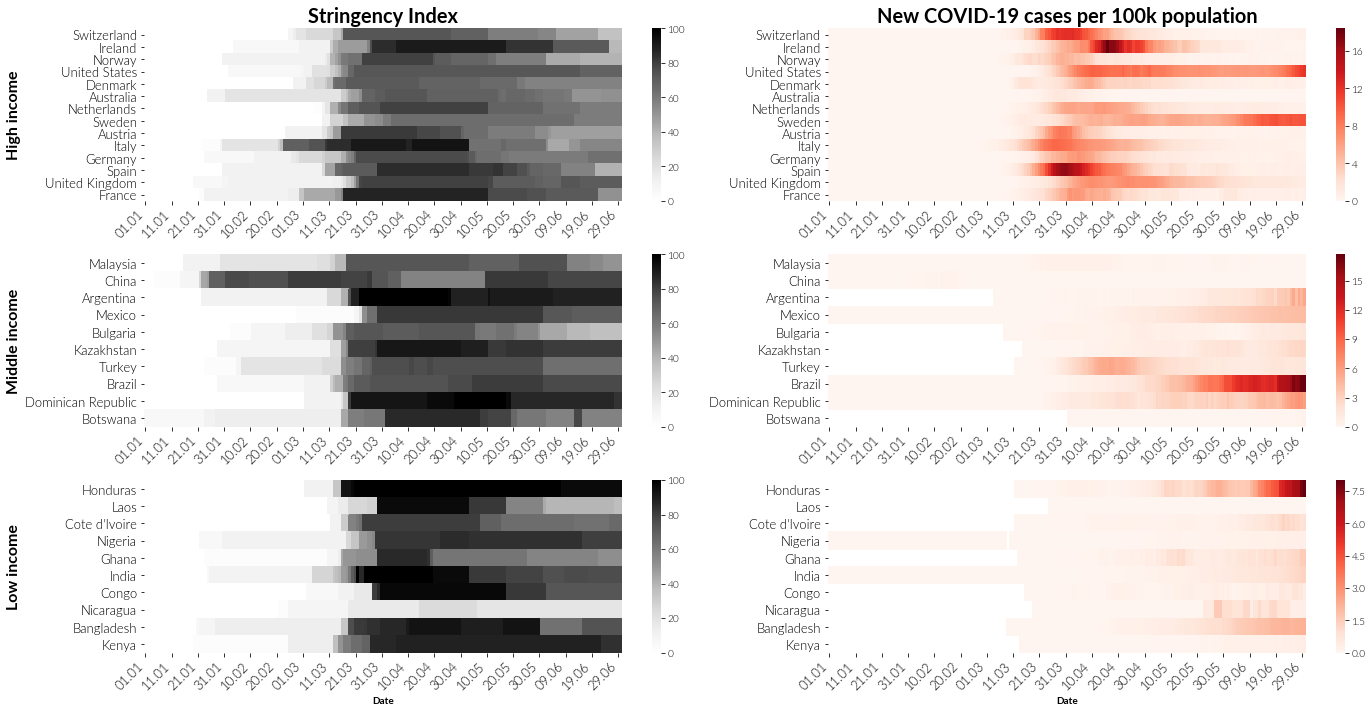

In [29]:
heatmap_2D_stringency_cases(gdf_world, df_ox, df_cases, 'cases_per_100000', 'original', '2020-01-01', '2020-06-30', df_gdp_per_capita)

0 ['Switzerland', 'Ireland', 'Norway', 'United States of America', 'Qatar', 'Denmark', 'Australia', 'Netherlands', 'Sweden', 'Austria']
1 ['Malaysia', 'China', 'Argentina', 'Mexico', 'Bulgaria', 'Kazakhstan', 'Turkey', 'Brazil', 'Dominican Rep.', 'Botswana']
2 ['Honduras', 'Laos', "Côte d'Ivoire", 'Nigeria', 'Ghana', 'India', 'Congo', 'Nicaragua', 'Bangladesh', 'Kenya']


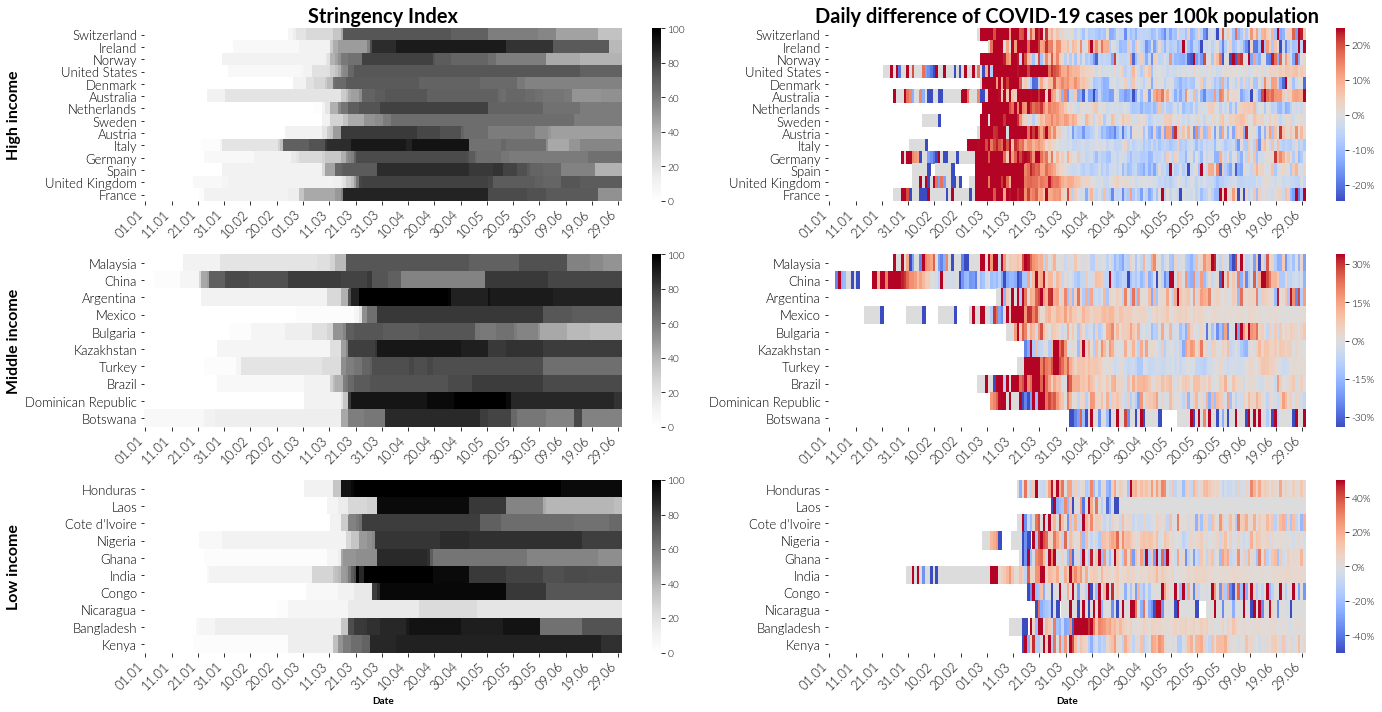

In [30]:
heatmap_2D_stringency_cases(gdf_world, df_ox, df_cases, 'cases_per_100000', 'daily_change', '2020-01-01', '2020-06-30', df_gdp_per_capita)